In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using Distributions
using PyPlot
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/auxiliary/buffer.jl")
include("../functions/preprocessing.jl")

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


fft_expand (generic function with 1 method)

# Complex normal distribution

In [2]:
# create random variable for vectors of gamma distributed RV's
mutable struct ComplexNormal <: ForneyLab.SoftFactor
    id::Symbol
    interfaces::Vector{Interface}
    i::Dict{Symbol,Interface}

    function ComplexNormal(out, μ, Γ, C; id=ForneyLab.generateId(ComplexNormal))
        @ensureVariables(out, μ, Γ, C)
        self = new(id, Array{Interface}(undef, 4), Dict{Symbol,Interface}())
        ForneyLab.addNode!(currentGraph(), self)
        self.i[:out] = self.interfaces[1] = ForneyLab.associate!(Interface(self), out)
        self.i[:μ] = self.interfaces[2] = ForneyLab.associate!(Interface(self), μ)
        self.i[:Γ] = self.interfaces[3] = ForneyLab.associate!(Interface(self), Γ)
        self.i[:C] = self.interfaces[4] = ForneyLab.associate!(Interface(self), C)

        return self
    end
end

format(dist::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}) = "$(slug(ComplexNormal))(μ=$(format(dist.params[:μ])), Γ=$(format(dist.params[:Γ])), C=$(format(dist.params[:C])))"

ProbabilityDistribution(::Type{ForneyLab.Multivariate}, ::Type{ComplexNormal}; μ::Array{Complex{Float64},1}, Γ::Array{Complex{Float64},2}, C::Array{Complex{Float64},2}) = ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}(Dict(:μ=>μ, :Γ=>Γ, :C=>C))
ProbabilityDistribution(::Type{ComplexNormal}; μ::Array{Complex{Float64},1}, Γ::Array{Complex{Float64},2}, C::Array{Complex{Float64},2}) = ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}(Dict(:μ=>μ, :Γ=>Γ, :C=>C))

function ForneyLab.prod!( x::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal},
                          y::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal},
                          z::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}=ProbabilityDistribution(ForneyLab.Multivariate, ComplexNormal, μ=zeros(size(x.params[:μ])).+0im, Γ=(1e10+1e10im)*Ic(length(x.params[:μ])), C=mat(0.0+0.0im)))

    # TOO SIMPLIFIED (CASE FOR C=0, possibly even wrong)
    z.params[:Γ] = inv(inv(x.params[:Γ]) + inv(y.params[:Γ])) .+ 0.0im
    z.params[:μ] = z.params[:Γ]*(inv(x.params[:Γ])*x.params[:μ] + inv(y.params[:Γ])*y.params[:μ]) .+ 0.0im
    z.params[:C] = mat(0.0+0.0im)
        
    return z
end

unsafeMean(dist::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}) = dist.params[:μ] # unsafe mean  
ForneyLab.unsafeMean(dist::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}) = dist.params[:μ] # unsafe mean  
unsafeCov(dist::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}) = dist.params[:Γ] # unsafe mean  
ForneyLab.unsafeCov(dist::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}) = dist.params[:Γ] # unsafe mean  

In [3]:
ruleSPComplexNormalOutNPPP(msg_out::Nothing, 
                           msg_μ::Message{PointMass},
                           msg_Γ::Message{PointMass},
                           msf_C::Message{PointMass}) =
                           Message(ForneyLab.Multivariate, ComplexNormal, μ=deepcopy(msg_μ.dist.params[:μ]), Γ=deepcopy(msg_Γ.dist.params[:Γ]), C=deepcopy(msg_C.dist.params[:C]))

ruleSPComplexNormalOutNPPP (generic function with 1 method)

In [4]:
ruleSPComplexNormalIn1PNPP(msg_out::Message{PointMass}, 
                           msg_μ::Nothing,
                           msg_Γ::Message{PointMass},
                           msf_C::Message{PointMass}) =
                           Message(ForneyLab.Multivariate, ComplexNormal, μ=deepcopy(msg_out.dist.params[:μ]), Γ=deepcopy(msg_Γ.dist.params[:Γ]), C=deepcopy(msg_C.dist.params[:C]))

ruleSPComplexNormalIn1PNPP (generic function with 1 method)

In [5]:
ruleVBComplexNormalOut(dist_out::Any,
                       dist_μ::ProbabilityDistribution{ForneyLab.Multivariate},
                       dist_Γ::ProbabilityDistribution{ForneyLab.MatrixVariate},
                       dist_C::ProbabilityDistribution{ForneyLab.MatrixVariate}) =
                       Message(ForneyLab.Multivariate, ComplexNormal, μ=ForneyLab.unsafeMean(dist_μ), Γ=ForneyLab.unsafeMean(dist_Γ), C=ForneyLab.unsafeMean(dist_C))

ruleVBComplexNormalOut (generic function with 1 method)

In [6]:
ruleVBComplexNormalIn1(dist_out::ProbabilityDistribution{ForneyLab.Multivariate},
                       dist_μ::Any,
                       dist_Γ::ProbabilityDistribution{ForneyLab.MatrixVariate},
                       dist_C::ProbabilityDistribution{ForneyLab.MatrixVariate}) =
                       Message(ForneyLab.Multivariate, ComplexNormal, μ=ForneyLab.unsafeMean(dist_out), Γ=ForneyLab.unsafeMean(dist_Γ), C=ForneyLab.unsafeMean(dist_C))

ruleVBComplexNormalIn1 (generic function with 1 method)

In [7]:
@sumProductRule(:node_type     => ComplexNormal,
                :outbound_type => Message{ComplexNormal},
                :inbound_types => (Nothing, Message{PointMass}, Message{PointMass}, Message{PointMass}),
                :name          => SPComplexNormalOutNPP)

@sumProductRule(:node_type     => ComplexNormal,
                :outbound_type => Message{ComplexNormal},
                :inbound_types => (Message{PointMass}, Nothing, Message{PointMass}, Message{PointMass}),
                :name          => SPComplexNormalIn1NPP)

@naiveVariationalRule(:node_type     => ComplexNormal,
                      :outbound_type => Message{ComplexNormal},
                      :inbound_types => (Nothing, ProbabilityDistribution, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VBComplexNormalOut)

@naiveVariationalRule(:node_type     => ComplexNormal,
                      :outbound_type => Message{ComplexNormal},
                      :inbound_types => (ProbabilityDistribution, Nothing, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VBComplexNormalIn1)

# Hierarchical Gaussian filter

In [8]:
mutable struct HGF <: ForneyLab.SoftFactor
    id::Symbol
    interfaces::Vector{Interface}
    i::Dict{Symbol,Interface}

    function HGF(X, ξ; id=ForneyLab.generateId(HGF))
        
        # ensure that the input arguments are random variables
        @ensureVariables(X, ξ) 
        
        # create new object
        self = new(id, Array{Interface}(undef, 2), Dict{Symbol,Interface}())
        
        # add the node to the current factor graph
        ForneyLab.addNode!(currentGraph(), self)
        
        # add argument variables to interfaces of node
        self.i[:X] = self.interfaces[1] = ForneyLab.associate!(Interface(self), X)
        self.i[:ξ] = self.interfaces[2] = ForneyLab.associate!(Interface(self), ξ)
        
        # return object
        return self
    end
end

In [9]:
function ruleVariationalHGFOutNP(marg_X::Nothing, 
                                 marg_ξ::ProbabilityDistribution{ForneyLab.Multivariate})
    
    # caluclate required mean
    mξ = ForneyLab.unsafeMean(marg_ξ)

    # calculate required variance
    vξ = diag(ForneyLab.unsafeCov(marg_ξ))

    # calculate new parameters
    mX = zeros(size(mξ)) .+ 0im
    vX = exp.(mξ - vξ/2) .+ 0im
    
    # create variational message
    return Message(ForneyLab.Multivariate, ComplexNormal, μ=mX, Γ=diagm(vX), C=mat(0.0+0.0im))

end

ruleVariationalHGFOutNP (generic function with 1 method)

In [59]:
function ruleVariationalHGFIn1PN(marg_X::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                 marg_ξ::Nothing)
    
    # calculate required means
    mX = ForneyLab.unsafeMean(marg_X)

    # calculate required variances
    vX = diag(ForneyLab.unsafeCov(marg_X))

    # calculate new parameters
    mξ = log.(mX.*conj.(mX) + vX)
    vξ = 1.0*ones(length(mξ))

    # create variational message
    Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=mξ./vξ, w=diagm(1 ./ vξ))

end

ruleVariationalHGFIn1PN (generic function with 1 method)

In [60]:
@naiveVariationalRule(:node_type     => HGF,
                      :outbound_type => Message{ComplexNormal},
                      :inbound_types => (Nothing, ProbabilityDistribution),
                      :name          => VariationalHGFOutNP)

@naiveVariationalRule(:node_type     => HGF,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (ProbabilityDistribution, Nothing),
                      :name          => VariationalHGFIn1PN)

## Factor graph

In [61]:
# number of frequency bins 
nr_freqs = 3

# create factor graph
fg = FactorGraph()

# gaussian mixture 
@RV [id=:ξ] ξ ~ GaussianMeanVariance(placeholder(:μ_ξ, dims=(nr_freqs,)), placeholder(:Σ_ξ, dims=(nr_freqs,nr_freqs)))

# HGF
@RV [id=:X] X ~ HGF(ξ)

# observation model
@RV [id=:y] y ~ ComplexNormal(X, placeholder(:Σ_y, dims=(nr_freqs,nr_freqs)), mat(0.0+0.0im))
placeholder(y, :y, dims=(nr_freqs,))

# draw graph
ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 18187904343674099567 -->
 18187904343674099567 
 
 placeholder_Σ_y 
 
<!-- 12311428296040511703 -->
 12311428296040511703 
 
 HGF 
 hgf_1 
 
<!-- 3295325314346229192 -->
 3295325314346229192 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 12311428296040511703--3295325314346229192 -->
 12311428296040511703--3295325314346229192 
 
 ξ 
 1 out 
 2 ξ 
 
<!-- 14415090586757634809 -->
 14415090586757634809 
 
 placeholder_μ_ξ 
 
<!-- 3295325314346229192--14415090586757634809 -->
 3295325314346229192--14415090586757634809 
 
 μ_ξ 
 1 out 
 2 m 
 
<!-- 18430006066804928135 -->
 18430006066804928135 
 
 placeholder_Σ_ξ 
 
<!-- 3295325314346229192--18430006066804928135 -->
 3295325314346229192--18430006066804928135 
 
 Σ_ξ 
 1 out 
 3 v 
 
<!-- 13802279350541791896 -->
 13802279350541791896 
 
 clamp_1 
 
<!-- 6319615108109639202 -->
 6319615108109639202 
 
 placeholder_y 
 
<!-- 16178619108164218730 -->
 16178619108164218730 
 
 ComplexNormal 
 complexnormal_1 
 
<!-- 6319615108109639202--16178619108164218730 -->
 6319615108109639202--16178619108164218730 
 
 y 
 1 out 
 1 out 
 
<!-- 16178619108164218730--18187904343674099567 -->
 16178619108164218730--18187904343674099567 
 
 Σ_y 
 1 out 
 3 Γ 
 
<!-- 16178619108164218730--12311428296040511703 -->
 16178619108164218730--12311428296040511703 
 
 X 
 1 X 
 2 μ 
 
<!-- 16178619108164218730--13802279350541791896 -->
 16178619108164218730--13802279350541791896 
 
 clamp_1 
 1 out 
 4 C

## Data generation

In [62]:
# generate data
N = 5000

μ_ξ = 1.0*collect(1:nr_freqs)
Σ_ξ = 1e0*diagm(collect(2:2:2*nr_freqs))
Σ_meas = 1e-10*Ic(nr_freqs)

ξ_samples = Array{Float64,2}(undef, N, nr_freqs)
X_samples = Array{Complex{Float64},2}(undef, N, nr_freqs)
y_samples = Array{Complex{Float64},2}(undef, N, nr_freqs)

for n = 1:N

    sample_ξ = rand(MvNormal(μ_ξ, Σ_ξ))
    sample_X = rand(MvNormal(zeros(nr_freqs), exp.(sample_ξ))) + 1im*rand(MvNormal(zeros(nr_freqs), exp.(sample_ξ))) 
    sample_y = rand(MvNormal(real(sample_X), Σ_meas)) + 1im*rand(MvNormal(imag(sample_X), Σ_meas))
    
    ξ_samples[n,:] = sample_ξ
    X_samples[n,:] = sample_X
    y_samples[n,:] = sample_y
    
end

t = collect(1:N)
;

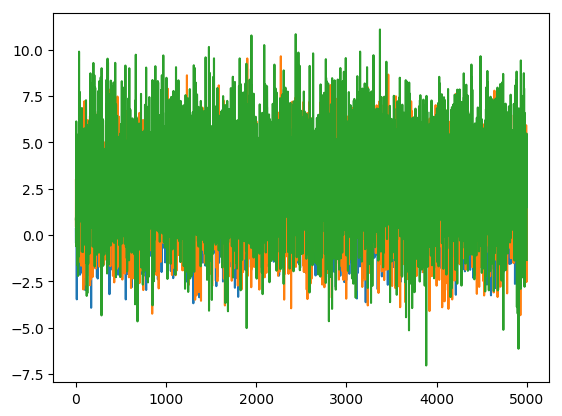

In [63]:
plt.plot(t, ξ_samples);

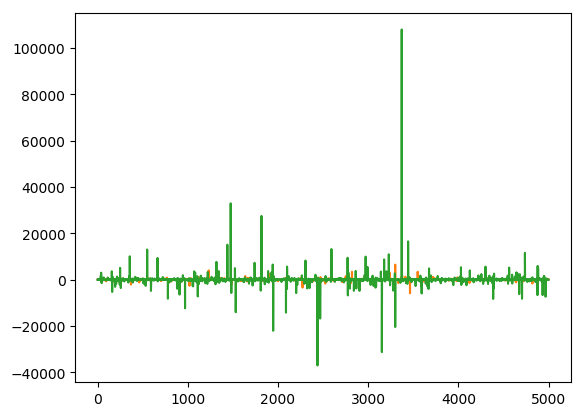

In [64]:
plt.plot(t, X_samples);

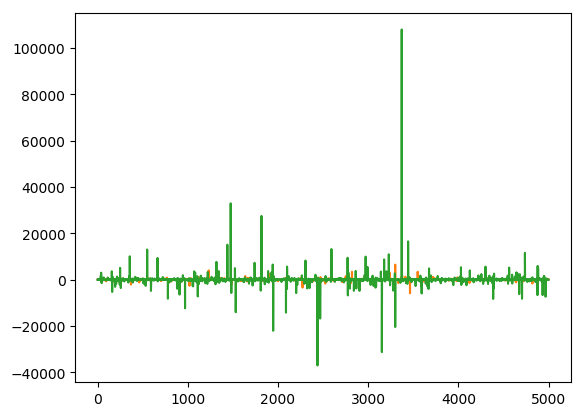

In [65]:
plt.plot(t,y_samples);

## Inference 

In [66]:
q = PosteriorFactorization(X, ξ, ids=[:X :ξ])
# generate algorithm
algo = variationalAlgorithm(q)
source_code = compatibility_fix(algorithmSourceCode(algo))
eval(Meta.parse(source_code))
println(source_code)

begin

function stepξ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:μ_ξ]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_ξ]))
messages[2] = ruleVariationalHGFIn1PN(marginals[:X], nothing)

marginals[:ξ] = messages[1].dist * messages[2].dist

return marginals

end

function stepX!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVariationalHGFOutNP(nothing, marginals[:ξ])
messages[2] = ruleVBComplexNormalIn1(ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:y]), nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_y]), ProbabilityDistribution(MatrixVariate, PointMass, m=mat(0.0 + 0.0im)))

marginals[:X] = messages[1].dist * messages[2].dist

return marginals

end

end # block


In [67]:
μ_ξ_mem = Array{Float64,2}(undef, N, nr_freqs)
Σ_ξ_mem = Array{Float64,2}(undef, N, nr_freqs)

# priors
μ_ξ = zeros(nr_freqs)
Σ_ξ = 10*Ic(nr_freqs)
Σ_y = 1e-10*Ic(nr_freqs) .+ 0im

marginals = Dict()

for n = 1:N
        
    # fill marginals dictionary
    marginals[:ξ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_ξ, v=Σ_ξ)
    
    # fill data dictionary
    data = Dict()
    data[:μ_ξ] = μ_ξ
    data[:Σ_ξ] = Σ_ξ
    data[:Σ_y] = Σ_y
    data[:y] = y_samples[n,:]
    
    # perform updates
    for _ in 1:5
        Base.invokelatest(stepX!, data, marginals)
        Base.invokelatest(stepξ!, data, marginals)
    end
    
    # update parameters
    μ_ξ = ForneyLab.unsafeMean(marginals[:ξ])
    Σ_ξ = ForneyLab.unsafeCov(marginals[:ξ])

    # save parameters
    μ_ξ_mem[n,:] = μ_ξ
    Σ_ξ_mem[n,:] = diag(Σ_ξ)
    
end

## Results

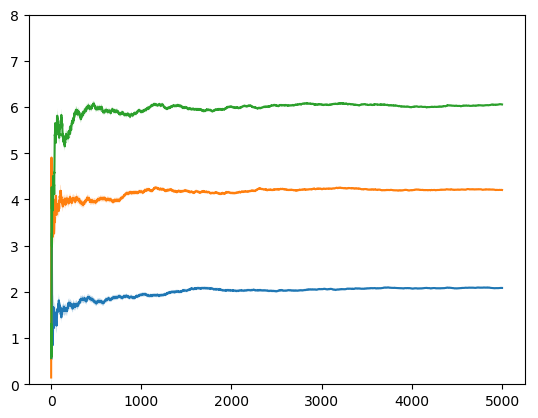

(0, 8)

In [68]:
for k = 1:nr_freqs
    plt.plot(t, μ_ξ_mem[:,k])
    plt.fill_between(t, μ_ξ_mem[:,k] - sqrt.(Σ_ξ_mem[:,k]), μ_ξ_mem[:,k] + sqrt.(Σ_ξ_mem[:,k]), alpha=0.3)
end
plt.ylim(0,8)


In [58]:
μ_ξ_mem

5000×3 Array{Float64,2}:
 2.74128   7.76242  2.80941
 1.09524  10.9294   4.35207
 3.78614   4.58774  5.67289
 3.51875   4.84818  3.97393
 3.98951   4.66119  5.60336
 3.24486   5.25609  5.34531
 3.0362    5.52345  6.33977
 2.57451   5.32755  6.27293
 2.77558   6.13334  6.89423
 2.64165   5.63122  6.39827
 2.4841    5.49008  6.11636
 2.9553    4.81279  5.01264
 2.92645   4.85052  4.98035
 ⋮                         
 2.11869   4.11632  6.10864
 2.11866   4.11563  6.10988
 2.118     4.11485  6.11001
 2.11638   4.11437  6.1103 
 2.11613   4.11633  6.11169
 2.11668   4.11509  6.11283
 2.11614   4.11557  6.11353
 2.11489   4.11631  6.1147 
 2.11551   4.11468  6.11488
 2.11509   4.11556  6.11367
 2.11543   4.11623  6.11335
 2.11601   4.11486  6.11214